In [ ]:
# !git clone https://github.com/aliasvishnu/EEGNet.git
!pip install mne
# !pip install librosa
# mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 2.9 MB/s 


In [ ]:
import torch
import torchvision
import mne
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib.image as mpimg
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import librosa
from sklearn.preprocessing import normalize
import os
from mne.time_frequency import tfr_morlet,  tfr_array_morlet
from mne.baseline import rescale
from mne.viz import centers_to_edges
from google.colab.patches import cv2_imshow
import cv2
import io

In [ ]:
# model

In [ ]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = (sample_data_folder / 'MEG' / 'sample' /
                        'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file)

Using default location ~/mne_data for sample...
Creating ~/mne_data


100%|██████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 390GB/s]
Untarring contents of '/root/mne_data/MNE-sample-data-processed.tar.gz' to '/root/mne_data'


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


In [ ]:
# ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
# orig_raw = raw.copy()
# raw.load_data()
# # ica.apply(raw)

# # show some frontal channels to clearly illustrate the artifact removal
# chs = ['MEG 0111', 'MEG 0121', 'MEG 0131', 'MEG 0211', 'MEG 0221', 'MEG 0231',
#        'MEG 0311', 'MEG 0321', 'MEG 0331', 'MEG 1511', 'MEG 1521', 'MEG 1531',
#        'EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006',
#        'EEG 007', 'EEG 008']
# chan_idxs = [raw.ch_names.index(ch) for ch in chs]
# orig_raw.plot(order=chan_idxs, start=12, duration=4)
# raw.plot(order=chan_idxs, start=12, duration=4)

root = mne.datasets.sample.data_path() / 'MEG' / 'sample'
raw_file = root / 'sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_file, preload=False)

# events_file = root / 'sample_audvis_filt-0-40_raw-eve.fif'
# events = mne.read_events(events_file)

# raw.crop(tmax=90)  # in seconds (happens in-place)
# discard events >90 seconds (not strictly necessary, but avoids some warnings)
# events = events[events[:, 0] <= raw.last_samp]
# events = mne.find_events(raw, stim_channel='EEG 003')
events = mne.find_events(raw, stim_channel='STI 014')
picks = mne.pick_types(raw.info, meg='grad', eeg=True, eog=True, stim=False)
print(events[:5])  # show the first 5

Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
319 events found
Event IDs: [ 1  2  3  4  5 32]
[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


In [ ]:
# event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
#               'visual/right': 4, 'smiley': 5, 'buttonpress': 32}
# reject_criteria = dict(mag=4000e-15,     # 4000 fT
#                        grad=4000e-13,    # 4000 fT/cm
#                        eeg=150e-6,       # 150 µV
#                        eog=250e-6)       # 250 µV
# epochs = mne.Epochs(raw, events, event_id=event_dict, tmin=-0.2, tmax=0.5,
#                     reject=reject_criteria, preload=True)

event_id, tmin, tmax = 1, -1., 3.
baseline = (None, 0)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    baseline=baseline, reject=dict(grad=4000e-13, eog=350e-6),
                    preload=True)

Not setting metadata
72 matching events found
Setting baseline interval to [-0.9989760657919393, 0.0] sec
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
4 projection items activated
Loading data for 72 events and 601 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
5 bad epochs dropped


In [ ]:
# conds_we_care_about = ['auditory/left', 'auditory/right',
#                        'visual/left', 'visual/right']
# epochs.equalize_event_counts(conds_we_care_about)  # this operates in-place
# aud_epochs = epochs['auditory']
# vis_epochs = epochs['visual']
# del raw, epochs  # free up memory


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


(262, 5, 201)
Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Applying baseline correction (mode: logratio)


[Parallel(n_jobs=1)]: Done 262 out of 262 | elapsed:    3.7s finished


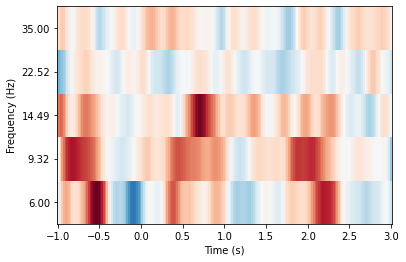

In [ ]:
# data = raw.pick(['eeg', 'eog']).load_data()
# frequencies = np.arange(7, 30, 3)
# power = mne.time_frequency.tfr_morlet(aud_epochs, n_cycles=2, return_itc=False,
#                                       freqs=frequencies, decim=3)
# power.plot(['EEG 004'])

freqs = np.logspace(*np.log10([6, 35]), num=5)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=None)
# print(power.ch_names[-2])
# power.plot_topo(baseline=(-0.5, 0), mode='logratio', title='Average power')
print(power.data.shape)
fig = power._plot([-2], baseline=(-0.5, 0), colorbar=False, mode='logratio', axes=None, layout=None)[0]
# fig, axis = plt.subplots(1, 2, figsize=(7, 4))
# power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=8, fmax=12,
#                    baseline=(-0.5, 0), mode='logratio', axes=axis[0],
#                    title='Alpha', show=False)
# power.plot_topomap(ch_type='grad', tmin=0.5, tmax=1.5, fmin=13, fmax=25,
#                    baseline=(-0.5, 0), mode='logratio', axes=axis[1],
#                    title='Beta', show=False)
# mne.viz.tight_layout()
# plt.show()

In [ ]:
# the rest is matplotlib commands for manipulating figure/axes elements
fig.suptitle('')  # remove the title
# you can print fig.axes to determine which is the image and which is the colorbar
# fig.axes[1].remove()  # remove colorbar
fig.axes[0].set_axis_off()  # remove ticks, etc
fig.axes[0].set_position((0,0,1,1))  # remove margins
fig.savefig('whatever.png')
img = mpimg.imread('whatever.png')

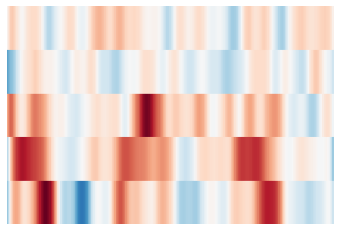

In [ ]:
plt.axis('off')
plt.imshow(img_2)
plt.show()

In [ ]:
# print(img.shape)
# print(img.dtype)
# print(img)
# img = img[:,:,0:3]

In [ ]:
print(img.shape)
print(img.dtype)
print(img)

(288, 432, 3)
float32
[[[0.9764706  0.9411765  0.92156863]
  [0.9764706  0.9411765  0.92156863]
  [0.99215686 0.8666667  0.79607844]
  ...
  [0.9764706  0.9372549  0.9137255 ]
  [0.9764706  0.9372549  0.9137255 ]
  [0.9764706  0.9372549  0.9137255 ]]

 [[0.9764706  0.9411765  0.92156863]
  [0.9764706  0.9411765  0.92156863]
  [0.99215686 0.8666667  0.79607844]
  ...
  [0.9764706  0.9372549  0.9137255 ]
  [0.9764706  0.9372549  0.9137255 ]
  [0.9764706  0.9372549  0.9137255 ]]

 [[0.9764706  0.9411765  0.92156863]
  [0.9764706  0.9411765  0.92156863]
  [0.99215686 0.8666667  0.79607844]
  ...
  [0.9764706  0.9372549  0.9137255 ]
  [0.9764706  0.9372549  0.9137255 ]
  [0.9764706  0.9372549  0.9137255 ]]

 ...

 [[0.60784316 0.7882353  0.8784314 ]
  [0.60784316 0.7882353  0.8784314 ]
  [0.89411765 0.93333334 0.95686275]
  ...
  [0.8117647  0.89411765 0.9372549 ]
  [0.8117647  0.89411765 0.9372549 ]
  [0.8117647  0.89411765 0.9372549 ]]

 [[0.60784316 0.7882353  0.8784314 ]
  [0.60784316 0

In [ ]:
# def fig2data ( fig ):
#     # draw the renderer
#     fig.canvas.draw ( )
 
#     # Get the RGBA buffer from the figure
#     w,h = fig.canvas.get_width_height()
#     buf = np.fromstring ( fig.canvas.tostring_argb(), dtype=np.uint8 )
#     buf.shape = ( w, h,4 )
 
#     # canvas.tostring_argb give pixmap in ARGB mode. Roll the ALPHA channel to have it in RGBA mode
#     buf = np.roll ( buf, 3, axis = 2 )
#     return buf
# def plt2arr(fig, draw=True):
#     if draw:
#         fig.canvas.draw()
#     rgba_buf = fig.canvas.buffer_rgba()
#     (w,h) = fig.canvas.get_width_height()
#     rgba_arr = np.frombuffer(rgba_buf, dtype=np.uint8).reshape((h,w,4))
#     return rgba_arr

def get_img_from_fig(fig, dpi=180):
    fig.axes[0].get_xaxis().set_visible(False)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].set_axis_off()
    fig.axes[0].set_position((0,0,1,1))
    buf = io.BytesIO()
    # plt.savefig('test.png', bbox_inches='tight',pad = 0, dpi = 180)
    fig.savefig(buf, format="png", bbox_inches='tight',pad = 0,dpi=fig.dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

(302, 446, 3)


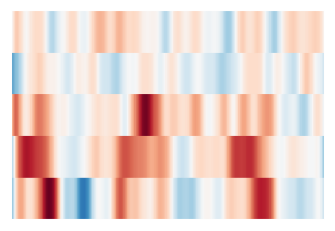

In [ ]:
# img = np.array(data_pow.canvas.renderer.buffer_rgba())
# img.shape
# itc.data.shape
# data_pow.axes.get_xaxis().set_visible(False)
# data_pow.axes.get_yaxis().set_visible(False)
fig.axes[0].get_xaxis().set_visible(False)
fig.axes[0].get_yaxis().set_visible(False)
# data_pow
img_orig_1 = get_img_from_fig(fig)
print(img_orig_1.shape)
plt.axis('off')
# cv2_imshow(img_orig_1)
plt.imshow(img_orig_1)
plt.show()
# del(img_orig)

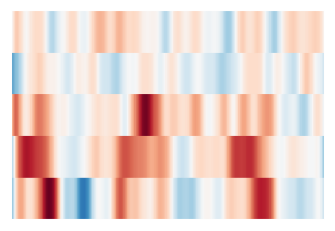

In [ ]:
# data_pow.axes[0].get_xaxis().set_visible(False)
# data_pow.axes[0].get_yaxis().set_visible(False)
img_orig_2 = get_img_from_fig(fig)
plt.axis('off')
plt.imshow(img_orig_2)
plt.savefig('test.png', bbox_inches='tight',pad = 0, dpi = 180)
plt.show()

In [ ]:
# signal = data.get_data(['EEG 003']).squeeze()
# print(signal.shape)
# data_pow.data

In [ ]:
# plt.plot(signal)
# plt.show()

In [ ]:
# powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(signal, Fs=150.15)

# plt.xlabel('Time')

# plt.ylabel('Frequency')

 

# plt.show()  


# # powerSpectrum = 10*math.log10(powerSpectrum.flatten())
# # powerSpectrum.flatten().shape
# data = imageAxis.get_array().data
# data = data.astype(int)
# # data = data.astype(np.double)
# print(data)
# print(data.dtype)
# img = np.stack((data,data,data))
# # img = img.astype(np.double)
# print(img.shape)
# print(img.dtype)

In [ ]:
# mel = librosa.feature.melspectrogram(signal, sr=150.15, n_fft=256, hop_length=128)

In [ ]:
# img = torch.tensor(img)
# img = img.type(torch.LongTensor)
# # img = img.double()
# # img = img.reshape(1,img.shape[0],img.shape[1])
# print(img.shape)
# print(img.dtype)
# log_mel_1 = librosa.power_to_db(mel)
# log_mel_1 = np.flipud(log_mel_1)
# # print(mel)
# print(log_mel.dtype)
# log_mel = log_mel_1.astype(np.double)
# print(log_mel.dtype)
# log_mel = np.stack((log_mel, log_mel, log_mel))
# img = torch.tensor(log_mel, dtype=torch.float32)
# # img = img.type(torch.LongTensor)
# print(img.dtype)

In [ ]:
# plt.imshow(log_mel_1)
# plt.show()

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
layers = [2,4,7,9,12,14,16,19,21,23,26,28,30]

In [ ]:
def uae(f_map):
  value=0
  for i in range(f_map.shape[0]):
    for j in range(f_map.shape[1]):
      for k in range(f_map.shape[2]):
        value = value + f_map[i][j][k]
  return value/(f_map.shape[0]*f_map.shape[1]*f_map.shape[2])

In [ ]:
def energy_map(f_map):
  map = np.zeros((f_map.shape[1], f_map.shape[2]))
  for i in range(f_map.shape[0]):
    map = map + f_map[i]
  map = map/f_map.shape[0]
  return map

In [ ]:
# model_new = torch.nn.Sequential(*list(model.children())[0][:9])
# print(model_new)
img = img_orig_2.reshape(img_orig_2.shape[2],img_orig_2.shape[0],img_orig_2.shape[1])
print(img.shape)
img = torch.tensor(img, dtype=torch.float32)

(3, 235, 352)


In [ ]:
value = []
for i in layers:
  model_new = torch.nn.Sequential(*list(model.children())[0][:i])
  res = model_new(img)
  res = res.detach().numpy()
  value.append(uae(res))

In [ ]:
# res.shape
# res = res.detach().numpy()
# res.shape

In [ ]:
# plt.imshow(res[0])
# plt.show()
print(res.shape)
# plt.figure(figsize=(20, 20))
# for i in range(res.shape[0]):
#   ax = plt.subplot(10, 13, i+1)
#   plt.imshow(res[i])
#   plt.title("layer "+str(i))
#   plt.axis("off")
# plt.tight_layout()

(512, 14, 22)


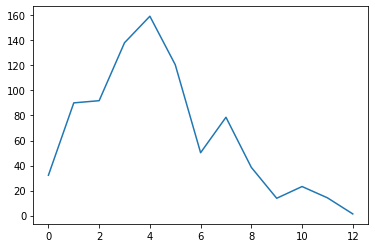

In [ ]:
plt.plot(value)
plt.show()

In [ ]:
model_test = torch.nn.Sequential(*list(model.children())[0][:layers[4]])
res = model_test(img)
res = res.detach().numpy()
res_energy = energy_map(res)

In [ ]:
res_energy.shape

(58, 88)

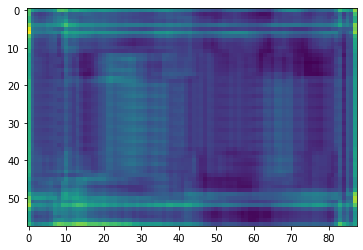

In [ ]:
plt.imshow(res_energy)
plt.show()

In [ ]:
res_energy_scaled = cv2.resize(res_energy,(352,235), interpolation = cv2.INTER_LINEAR)

In [ ]:
res_energy_scaled.shape

(235, 352)

In [ ]:
# plt.imshow(res_energy_scaled)
# plt.show()
# plt.hist(res_energy_scaled.ravel(), bins=256, range=(110.0, 300.0), fc='k', ec='k')
# np.min(res_energy_scaled)
res_energy_scaled_bin = res_energy_scaled.copy()
res_energy_scaled_bin[res_energy_scaled >= 200] = 1
res_energy_scaled_bin[res_energy_scaled < 200] = 0

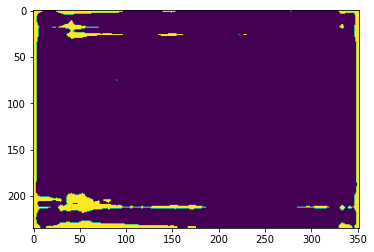

In [ ]:
plt.imshow(res_energy_scaled_bin)
plt.show()

In [ ]:
img = img.detach().numpy()

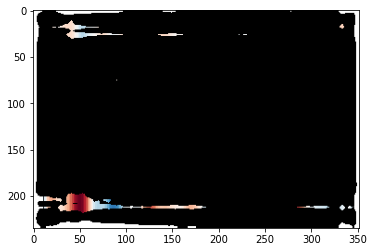

In [ ]:
array_data = img_orig_2.copy()
array_data[np.where(res_energy_scaled_bin == 0)] = 0
plt.imshow(array_data)
plt.show()